In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)

In [7]:
config = {
            'primitives': 'all',
            'truncate': {},
            'validation_size': -1,
            'test_size': -1,
            'on-the-fly': False,
            'cache_in_memory': False,
            'suffix': None,
            'add_augmentation_to_test_set': False,
            'num_parallel_calls': 10,
            'generation': {
                'split_sizes': {'training': 10000, 'validation': 200, 'test': 500},
                'image_size': [960, 1280],
                'random_seed': 0,
                'params': {
                    'generate_background': {
                        'min_kernel_size': 150, 'max_kernel_size': 500,
                        'min_rad_ratio': 0.02, 'max_rad_ratio': 0.031},
                    'draw_stripes': {'transform_params': (0.1, 0.1)},
                    'draw_multiple_polygons': {'kernel_boundaries': (50, 100)}
                },
            },
            'preprocessing': {
                'resize': [240, 320],
                'blur_size': 11,
            },
            'augmentation': {
                'photometric': {
                    'enable': True,
                    'primitives': 'all',
                    'params': {
                        'random_brightness': {'max_abs_change': 75},
                        'random_contrast': {'strength_range': [0.3, 1.8]},
                        'additive_gaussian_noise': {'stddev_range': [0, 15]},
                        'additive_speckle_noise': {'prob_range': [0, 0.0035]},
                        'additive_shade':{
                            'transparency_range': [-0.5, 0.8],
                            'kernel_size_range': [50, 100]},
                        'motion_blur': {'max_kernel_size': 7}},
                    'random_order': True,
                },
                'homographic': {
                    'enable': True,
                    'params': {
                        'translation': True,
                        'rotation': True,
                        'scaling': True,
                        'perspective': True,
                        'scaling_amplitude': 0.2,
                        'perspective_amplitude_x': 0.2,
                        'perspective_amplitude_y': 0.2,
                        'patch_ratio': 0.8,
                        'max_angle': 1.57,  # 3.14
                        'allow_artifacts': True,
                        'translation_overflow': 0.05,
                        'valid_border_margin': 2,
                    },
                    'valid_border_margin': 0,
                },
            }
    }

In [8]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [9]:
# code for photometric augmentation

primitives_photo = parse_primitives(config['primitives'], photaug.augmentations)

prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

indices = tf.range(len(primitives_photo))
if config['augmentation']['photometric']['random_order']:
    indices = tf.random.shuffle(indices)
def photo_aug_step(i, image):
    fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
                for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
    image = tf.case(fn_pairs)
    return i + 1, image

In [10]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [11]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.001,
            'descriptor_size': 256,
            'batch_size': 2,
            'epochs': 25,
            'learning_rate': 0.0001,
            'lambda_d': 0.05,
            'descriptor_size': 256,
            'positive_margin': 1.0,
            'negative_margin': 0.2,
            'lambda_loss': 10000,
            'nms': 4,
            'top_k': 0
    }

In [12]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_path, point_path, homography_path, 
                 warped_image_path, warped_point_path, 
                 image_size_x = 320, image_size_y = 240,
                 is_training = True, batch_size = model_config['batch_size']):
        
        self.__ids = os.listdir(image_path)
        self.__image_path = image_path
        self.__point_path = point_path
        self.__homography_path = homography_path
        
        self.__warped_image_path = warped_image_path
        self.__warped_point_path = warped_point_path
        
        self.__image_size_x = image_size_x
        self.__image_size_y = image_size_y
        self.__batch_size = batch_size
        self.__is_training = is_training
        self.on_epoch_end()
        
    def __getitem__(self, index):
        images = []
        points_maps = []
        points_list = []
        
        homography_list = []
        
        warped_images = []
        warped_points_maps = []
        warped_points_list = []
        
        valid_masks = []
        
        if (index + 1)*self.__batch_size > len(self.__ids):
            self.__batch_size = len(self.__ids) - index * self.__batch_size
            
        file_batch = self.__ids[index * self.__batch_size : (index + 1) * self.__batch_size]
        
        for id_name in file_batch:
            img_file = os.path.join(self.__image_path,id_name)
            image = cv2.imread(img_file, 0)
            image = cv2.resize(image , (self.__image_size_x , self.__image_size_y))
            image = np.expand_dims(image, axis = 2)
            image_shape = tf.shape(image)[:2]
            
            point_file = os.path.join(self.__point_path,id_name+'.npy')
            points = _read_points(point_file)
            points = np.round(points).astype(int)
            
            if self.__is_training:
                # add photometric_augmentation
                _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
                                 photo_aug_step, [0, image], parallel_iterations=1)              
                
                # read homography file
                homography_file = os.path.join(self.__homography_path, id_name+'.npy')
                homography = _read_points(homography_file)
                
                # read warped image
                warped_img_file = os.path.join(self.__warped_image_path,id_name)
                warped_image = cv2.imread(warped_img_file, 0)        
                
                # compute valid mask
                valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['valid_border_margin'])
                
                # read warped points
                warped_point_file = os.path.join(self.__warped_point_path,id_name+'.npy')
                warped_points = _read_points(warped_point_file)
                warped_points = filter_points(warped_points, image_shape)
                warped_points = np.round(warped_points).astype(int)
    
                warped_kp = tf.minimum(warped_points, image_shape-1)
                warped_points_map = tf.scatter_nd(warped_kp, tf.ones([tf.shape(warped_kp)[0]], 
                                                                     dtype=tf.int32), image_shape)
                        
                
                homography_list.append(homography)
                warped_image = warped_image / 255.0
                warped_images.append(warped_image)
                valid_masks.append(valid_mask)
                warped_points_list.append(warped_points)
                warped_points_maps.append(warped_points_map)

            kp = tf.minimum(points, image_shape-1)
            points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
            image = image / 255.0
            images.append(image)
            
            points_maps.append(points_map)
            points_list.append(points)
            
            
            
        images = np.array(images)
        if self.__is_training:
            warped_images = np.array(warped_images)
            warped_images = np.expand_dims(warped_images, axis = 3)
            homography_list = np.array(homography_list)
            warped_images = np.array(warped_images)
            valid_masks = np.expand_dims(valid_masks, axis = 3)
            dummy_loss_target = np.zeros(self.__batch_size)
            points_maps = np.expand_dims(points_maps, axis = 3)
            warped_points_maps = np.expand_dims(warped_points_maps, axis = 3)
            return [images, 
                    homography_list, 
                    warped_images, 
                    valid_masks, 
                    points_maps,
                    warped_points_maps], [dummy_loss_target, dummy_loss_target, dummy_loss_target]
   
           
    def __len__(self):
        return int(np.ceil(len(self.__ids) / float(self.__batch_size)))
    
    def on_epoch_end(self):
        pass

In [13]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size, kernel_initializer='he_uniform',
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [14]:
def shared_encoder(model_config, shape = (240, 320,1)):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    inputs = Input(shape)
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    return keras.models.Model(inputs = inputs, outputs = conv8, name = 'shared_encoder')

In [15]:
def detector_head(model_config, shape = (30, 40, 128)):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel

    inputs = Input(shape)
    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, 1+pow(model_config['grid_size'], 2), 1, 'conv2',
                      activation=None, **params_conv)

#     prob = tf.nn.softmax(x, axis=cindex)
#     # Strip the extra “no interest point” dustbin
#     prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
#     prob = tf.nn.depth_to_space(
#               prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     prob = tf.squeeze(prob, axis=cindex)
#     return {'logits': x, 'prob': prob}
    return keras.models.Model(inputs = inputs, outputs = x, name = 'detector_head')

In [16]:
def detector_loss(keypoint_map, logits, valid_mask=None):
    
    if model_config['data_format'] == 'channels_first':
        logits = tf.transpose(logits, [0, 2, 3, 1])
    # Convert the boolean labels to indices including the "no interest point" dustbin
    labels = keypoint_map#[..., tf.newaxis]  # for GPU
    labels = tf.cast(labels, tf.float32)
    labels = tf.nn.space_to_depth(labels, model_config['grid_size'])
    shape = tf.concat([tf.shape(labels)[:3], [1]], axis=0)
    labels = tf.concat([2*labels, tf.ones(shape)], 3)
    # Add a small random matrix to randomly break ties in argmax
    labels = tf.argmax(labels + tf.random.uniform(tf.shape(labels), 0, 0.1), axis=3)
    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones_like(keypoint_map) if valid_mask is None else valid_mask
#     valid_mask = valid_mask[..., tf.newaxis]  # for GPU
    valid_mask = tf.cast(valid_mask, tf.float32)
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.math.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.cast(valid_mask, tf.int64)
#     labels = labels * valid_mask
#     loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits, weights=valid_mask)
    return tf.reduce_mean(loss)

In [17]:
def descriptor_head(shape, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel
    inputs = Input(shape)
    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, model_config['descriptor_size'], 1, 'conv2',
                      activation=None, **params_conv)

#     desc = tf.transpose(x, [0, 2, 3, 1]) if cfirst else x
#     desc = tf.image.resize_bilinear(
#             desc, model_config['grid_size'] * tf.shape(desc)[1:3])
#     desc = tf.transpose(desc, [0, 3, 1, 2]) if cfirst else desc
#     desc = tf.nn.l2_normalize(desc, cindex)

#     return {'descriptors_raw': x, 'descriptors': desc}
    return keras.models.Model(inputs = inputs, outputs = x, name = 'descriptor_head')

In [18]:
def descriptor_loss(descriptors, warped_descriptors, homographies, valid_mask=None):
    # Compute the position of the center pixel of every cell in the image
    (batch_size, Hc, Wc) = tf.unstack(tf.cast(tf.shape(descriptors)[:3], tf.int32))
    coord_cells = tf.stack(tf.meshgrid(
        tf.range(Hc), tf.range(Wc), indexing='ij'), axis=-1)
    coord_cells = coord_cells * model_config['grid_size'] + model_config['grid_size'] // 2  # (Hc, Wc, 2)
    # coord_cells is now a grid containing the coordinates of the Hc x Wc
    # center pixels of the 8x8 cells of the image

    # Compute the position of the warped center pixels
    warped_coord_cells = warp_points(tf.reshape(coord_cells, [-1, 2]), homographies)
    # warped_coord_cells is now a list of the warped coordinates of all the center
    # pixels of the 8x8 cells of the image, shape (N, Hc x Wc, 2)

    # Compute the pairwise distances and filter the ones less than a threshold
    # The distance is just the pairwise norm of the difference of the two grids
    # Using shape broadcasting, cell_distances has shape (N, Hc, Wc, Hc, Wc)
    coord_cells = tf.cast(tf.reshape(coord_cells, [1, 1, 1, Hc, Wc, 2]), tf.float32)
    warped_coord_cells = tf.reshape(warped_coord_cells,
                                    [batch_size, Hc, Wc, 1, 1, 2])
    cell_distances = tf.norm(coord_cells - warped_coord_cells, axis=-1)
    s = tf.cast(tf.less_equal(cell_distances, tf.cast(model_config['grid_size'], tf.float32) - 0.5), tf.float32)
    # s[id_batch, h, w, h', w'] == 1 if the point of coordinates (h, w) warped by the
    # homography is at a distance from (h', w') less than config['grid_size']
    # and 0 otherwise

    # Normalize the descriptors and
    # compute the pairwise dot product between descriptors: d^t * d'
    descriptors = tf.reshape(descriptors, [batch_size, Hc, Wc, 1, 1, -1])
    descriptors = tf.nn.l2_normalize(descriptors, -1)
    warped_descriptors = tf.reshape(warped_descriptors,
                                    [batch_size, 1, 1, Hc, Wc, -1])
    warped_descriptors = tf.nn.l2_normalize(warped_descriptors, -1)
    dot_product_desc = tf.reduce_sum(descriptors * warped_descriptors, -1)
    dot_product_desc = tf.nn.relu(dot_product_desc)
    dot_product_desc = tf.reshape(tf.nn.l2_normalize(
        tf.reshape(dot_product_desc, [batch_size, Hc, Wc, Hc * Wc]),
        3), [batch_size, Hc, Wc, Hc, Wc])
    dot_product_desc = tf.reshape(tf.nn.l2_normalize(
        tf.reshape(dot_product_desc, [batch_size, Hc * Wc, Hc, Wc]),
        1), [batch_size, Hc, Wc, Hc, Wc])
    # dot_product_desc[id_batch, h, w, h', w'] is the dot product between the
    # descriptor at position (h, w) in the original descriptors map and the
    # descriptor at position (h', w') in the warped image

    # Compute the loss
    positive_dist = tf.maximum(0., model_config['positive_margin'] - dot_product_desc)
    negative_dist = tf.maximum(0., dot_product_desc - model_config['negative_margin'])
    loss = model_config['lambda_d'] * s * positive_dist + (1 - s) * negative_dist

    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones([batch_size,
                          Hc * model_config['grid_size'],
                          Wc * model_config['grid_size']], tf.float32)\
        if valid_mask is None else valid_mask
#     valid_mask = valid_mask[..., tf.newaxis] # for GPU
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.reshape(valid_mask, [batch_size, 1, 1, Hc, Wc])

    normalization = tf.reduce_sum(valid_mask) * tf.cast(Hc * Wc, tf.float32)
    # Summaries for debugging
    # tf.summary.scalar('nb_positive', tf.reduce_sum(valid_mask * s) / normalization)
    # tf.summary.scalar('nb_negative', tf.reduce_sum(valid_mask * (1 - s)) / normalization)
    tf.summary.scalar('positive_dist', tf.reduce_sum(valid_mask * model_config['lambda_d'] *
                                                     s * positive_dist) / normalization)
    tf.summary.scalar('negative_dist', tf.reduce_sum(valid_mask * (1 - s) *
                                                     negative_dist) / normalization)
    loss = tf.reduce_sum(valid_mask * loss) / normalization
    return loss

In [19]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss']*self.loss_fn(descriptors = inputs[0], 
                                                        warped_descriptors = inputs[1], 
                                                        homographies = inputs[2], 
                                                        valid_mask = inputs[3])
        self.add_loss(loss)
        return tf.reshape(loss, (1,))
#     def compute_output_shape(self, input_shape):
#         return [1]
    
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1])
        self.add_loss(loss)
        return loss
#     def compute_output_shape(self, input_shape):
#         return [1]

class WarpedDetectorLossLayer(Layer):
    def __init__(self, name='warped_detector_loss_layer', trainable=False):
        super(WarpedDetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1], 
                            valid_mask = inputs[2])
        self.add_loss(loss)
        return loss
#     def compute_output_shape(self, input_shape):
#         return [1]
    
def net():
    
    images_input = Input(shape = (240, 320,1), name = 'images_input')
    points_maps_input = Input(shape = (240, 320, 1), name = 'points_maps_input') 
    homography_list_input = Input(shape = (8,), name = 'homography_list_input') 
    warped_images_input = Input(shape = (240, 320, 1), name = 'warped_images_input')

    valid_masks_input = Input(shape = (240, 320,1), name = 'valid_masks_input')
    warped_points_maps_input = Input(shape = (240, 320, 1), name = 'warped_points_maps_input')
    
    homography_model = HomographyModel()
    homography = homography_model(homography_list_input)
    
    encoder = shared_encoder(model_config = model_config)
    encoder_output = encoder(images_input)
    warped_encoder_output = encoder(warped_images_input)
    
    detector = detector_head(model_config = model_config)
    detector_output = detector(encoder_output)
    warped_detector_output = detector(warped_encoder_output)
    
    descriptor = descriptor_head(shape = (30, 40, 128), model_config=model_config)
    descriptor_output = descriptor(encoder_output)
    warped_descriptor_output = descriptor(warped_encoder_output)

    detector_loss_layer = DetectorLossLayer()([points_maps_input, detector_output])
    warped_detector_loss_layer = WarpedDetectorLossLayer()([warped_points_maps_input, 
                                                warped_detector_output, 
                                                      valid_masks_input])
    
    descriptor_loss_layer = DescriptorLossLayer()([descriptor_output, warped_descriptor_output, 
                                          homography, valid_masks_input])
    
    model = keras.models.Model(inputs = [images_input, homography_list_input, warped_images_input, 
                                         valid_masks_input, points_maps_input, warped_points_maps_input],
                                        
                               outputs = [detector_loss_layer, warped_detector_loss_layer, 
                                          descriptor_loss_layer])
    return model

In [20]:
model = net()

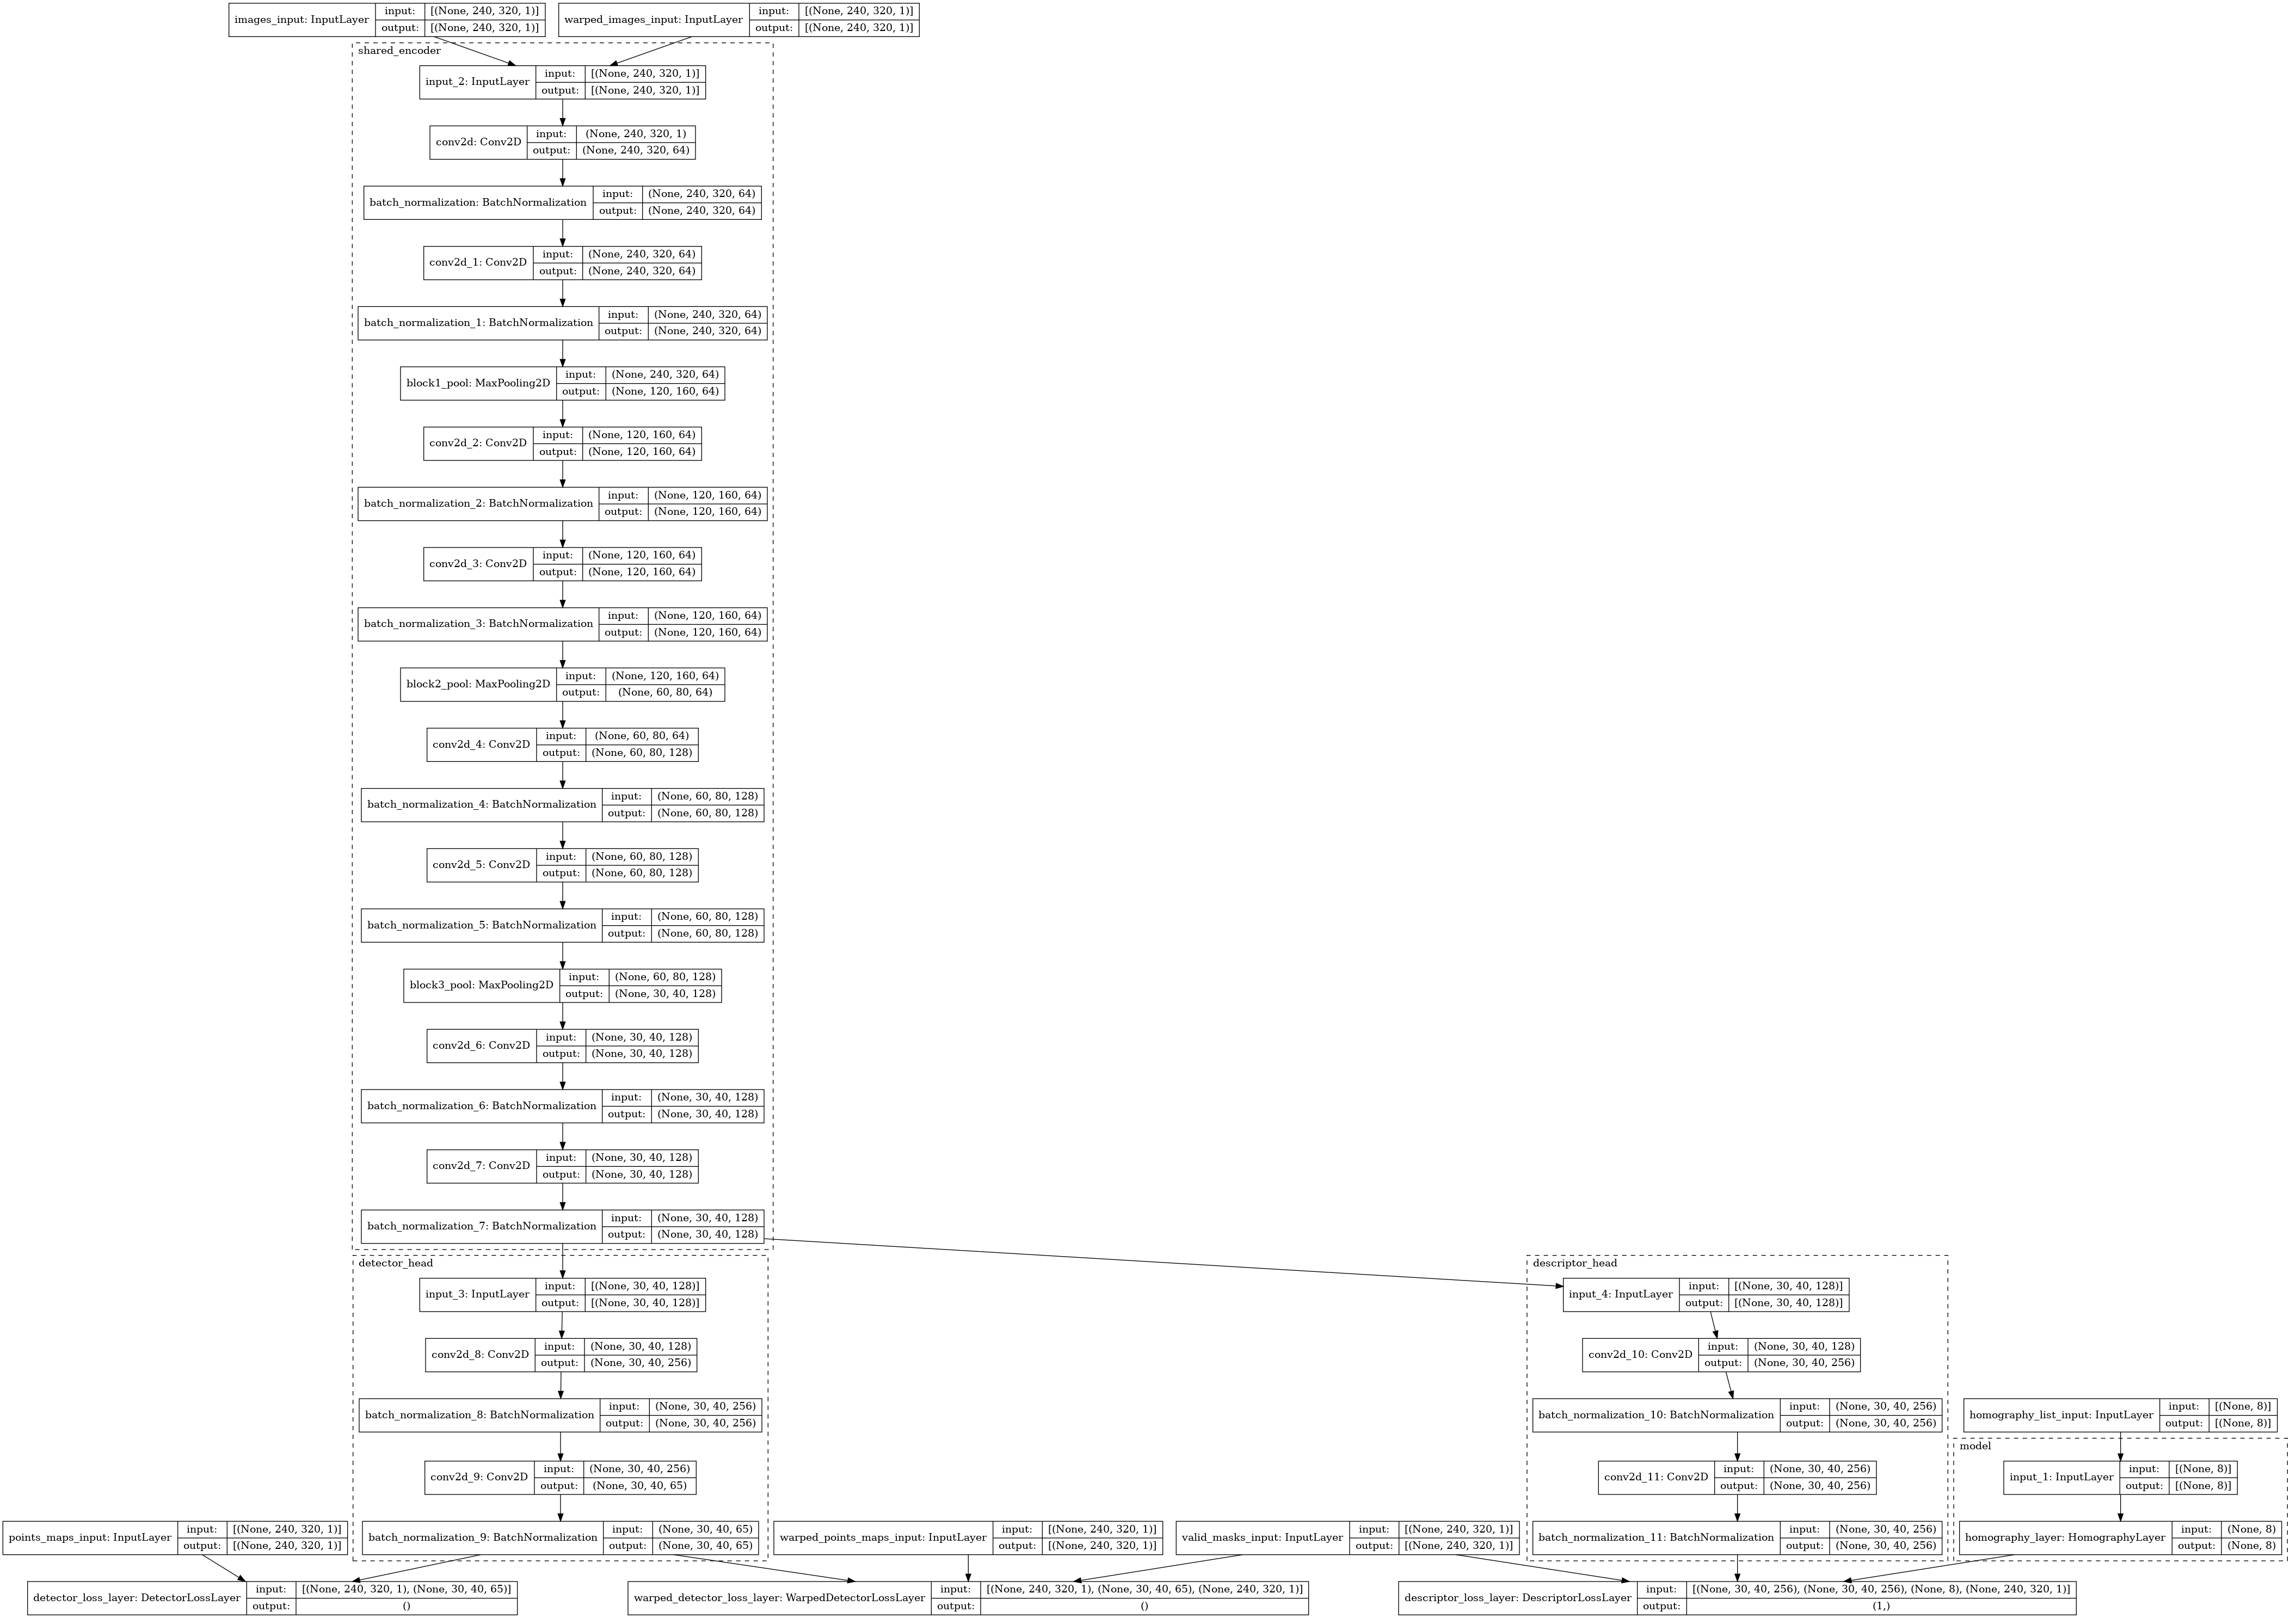

In [21]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=True, dpi=96)

In [22]:
def model_metrics(y_true, y_pred):
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    y_pred = tf.nn.softmax(y_pred, axis=cindex)
    y_pred = tf.argmax(y_pred, axis =cindex)
  
    y_pred = tf.one_hot(y_pred, depth = 1+pow(model_config['grid_size'], 2))
    y_true = tf.nn.space_to_depth(y_true, model_config['grid_size'])
    y_true = tf.cast(y_true, tf.float32)
    # Strip the extra “no interest point” dustbin
    y_pred = y_pred[:, :-1, :, :] if cfirst else y_pred[:, :, :, :-1]
   
    precision = tf.math.reduce_sum(y_pred * y_true) /tf.math.reduce_sum(y_pred)
    recall = tf.math.reduce_sum(y_pred * y_true) / tf.math.reduce_sum(y_true)
#     return {'precision': precision, 'recall': recall}
    return precision

In [23]:
def detect_loss(dummy_target, y_pred):
    return tf.squeeze(y_pred)

def descript_loss(dummy_target, y_pred):
    return tf.squeeze(y_pred)

def dummy_metrics(dummy_target, y_pred):
    return tf.squeeze(y_pred)

def dummy_metrics1(dummy_target, y_pred):
    return tf.squeeze(y_pred)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
              loss = [detect_loss,detect_loss, descript_loss],
             loss_weights=[1., 1., 1.])
#                        metrics = [model_metrics, dummy_metrics, dummy_metrics1])

In [24]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="/root/Internship-Valeo/Project/results/superpoint050222_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,)

TerminateOnNaN = tf.keras.callbacks.TerminateOnNaN()

In [25]:
image_path_train = '/root/Internship-Valeo/Project/data/COCO/anntrain2014'
point_path_train = '/root/Internship-Valeo/Project/data/COCO/pointstrain2014'
homography_path_train = '/root/Internship-Valeo/Project/data/COCO/homographies_train'

warped_image_path_train = '/root/Internship-Valeo/Project/data/COCO/warptrain2014'
warped_point_path_train = '/root/Internship-Valeo/Project/data/COCO/warped_pointstrain2014'


In [26]:
train_gen = DataGen(image_path = image_path_train, point_path = point_path_train, 
                   homography_path = homography_path_train,  
                   warped_image_path = warped_image_path_train, warped_point_path = warped_point_path_train, 
                    
                 image_size_x = 320, image_size_y = 240,
                 is_training = True, batch_size = model_config['batch_size'])


train_steps =  len(os.listdir(image_path_train))/model_config['batch_size']

In [27]:
image_path_val = '/root/Internship-Valeo/Project/data/COCO/annval2014'
point_path_val = '/root/Internship-Valeo/Project/data/COCO/pointsval2014'
homography_path_val = '/root/Internship-Valeo/Project/data/COCO/homographies_val'

warped_image_path_val = '/root/Internship-Valeo/Project/data/COCO/warpval2014'
warped_point_path_val = '/root/Internship-Valeo/Project/data/COCO/warped_pointsval2014'

In [28]:
val_gen = DataGen(image_path = image_path_val, point_path = point_path_val, 
                   homography_path = homography_path_val, 
                   warped_image_path = warped_image_path_val, warped_point_path = warped_point_path_val, 
                   
                 image_size_x = 320, image_size_y = 240,
                 is_training = True, batch_size = model_config['batch_size'])

In [43]:
history = model.fit(train_gen , validation_data = val_gen, steps_per_epoch = train_steps, 
                    epochs = 25, callbacks=[model_checkpoint_callback, TerminateOnNaN, tensorboard_callback])

Epoch 1/25
22587/22587 [==============================] - 6580s 291ms/step - loss: 9.5321 - detector_loss_layer_loss: 2.1571 - warped_detector_loss_layer_loss: 1.5771 - descriptor_loss_layer_loss: 1.0318 - val_loss: 6.3513 - val_detector_loss_layer_loss: 1.1072 - val_warped_detector_loss_layer_loss: 1.0055 - val_descriptor_loss_layer_loss: 1.0630

Epoch 00001: val_loss improved from inf to 6.35135, saving model to /root/Internship-Valeo/Project/results/superpoint050222_1
INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/superpoint050222_1/assets
Epoch 2/25
22587/22587 [==============================] - 6218s 275ms/step - loss: 5.8804 - detector_loss_layer_loss: 1.0335 - warped_detector_loss_layer_loss: 0.9000 - descriptor_loss_layer_loss: 1.0067 - val_loss: 5.8969 - val_detector_loss_layer_loss: 1.0018 - val_warped_detector_loss_layer_loss: 0.8974 - val_descriptor_loss_layer_loss: 1.0493

Epoch 00002: val_loss improved from 6.35135 to 5.89686, saving model to /r

22587/22587 [==============================] - 6389s 283ms/step - loss: 5.3140 - detector_loss_layer_loss: 0.9095 - warped_detector_loss_layer_loss: 0.7769 - descriptor_loss_layer_loss: 0.9706 - val_loss: 5.6206 - val_detector_loss_layer_loss: 0.9638 - val_warped_detector_loss_layer_loss: 0.8300 - val_descriptor_loss_layer_loss: 1.0165

Epoch 00016: val_loss did not improve from 5.61834
Epoch 17/25
22587/22587 [==============================] - 6180s 274ms/step - loss: 5.3085 - detector_loss_layer_loss: 0.9087 - warped_detector_loss_layer_loss: 0.7755 - descriptor_loss_layer_loss: 0.9701 - val_loss: 5.6481 - val_detector_loss_layer_loss: 0.9649 - val_warped_detector_loss_layer_loss: 0.8426 - val_descriptor_loss_layer_loss: 1.0166

Epoch 00017: val_loss did not improve from 5.61834
Epoch 18/25
22587/22587 [==============================] - 6155s 272ms/step - loss: 5.3028 - detector_loss_layer_loss: 0.9079 - warped_detector_loss_layer_loss: 0.7741 - descriptor_loss_layer_loss: 0.9694 - v

In [44]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-14022022-latest')

INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-14022022-latest/assets


In [ ]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco')

In [29]:
x,y = train_gen.__getitem__(0)

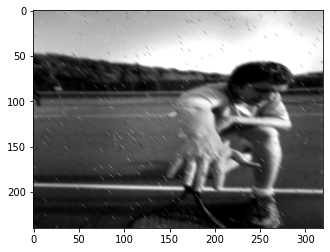

In [30]:
plt.imshow(x[0][0]*255, cmap = 'gray')

In [31]:
x[1][0]

array([ 7.5215429e-01, -1.5392347e-01, -2.0744205e+01, -1.8248303e-02,
        8.5725790e-01,  5.3621788e+00, -8.2092226e-04, -2.9155086e-05],
      dtype=float32)

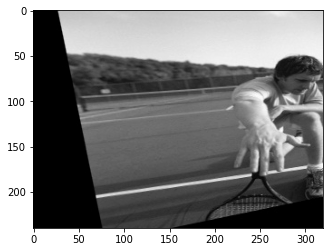

In [32]:
plt.imshow(x[2][0]*255, cmap = 'gray')

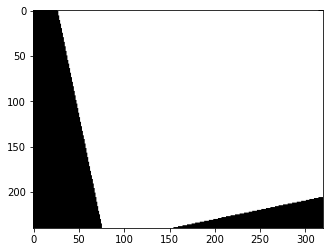

In [33]:
plt.imshow(x[3][0], cmap = 'gray')

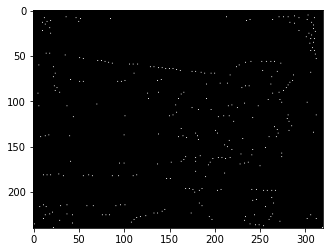

In [34]:
plt.imshow(x[4][0], cmap = 'gray')

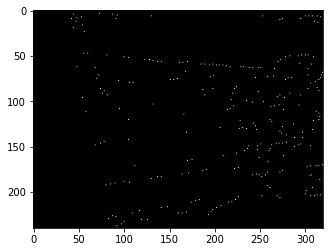

In [35]:
plt.imshow(x[5][0], cmap = 'gray')

In [36]:
x, y = val_gen.__getitem__(0)

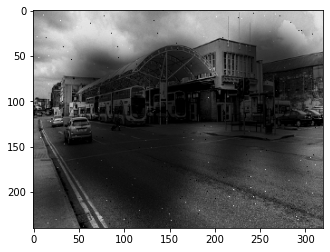

In [37]:
plt.imshow(x[0][0]*255, cmap = 'gray')

In [38]:
x[1][0]

array([-3.6591777e-01,  6.7505383e-01,  8.3416885e+01, -6.3661313e-01,
        1.3732436e-01,  1.5219792e+02, -2.6530968e-03,  2.8562326e-05],
      dtype=float32)

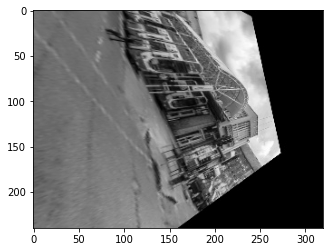

In [39]:
plt.imshow(x[2][0]*255, cmap = 'gray')

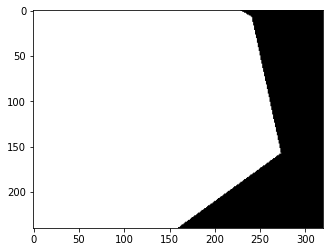

In [40]:
plt.imshow(x[3][0]*255, cmap = 'gray')

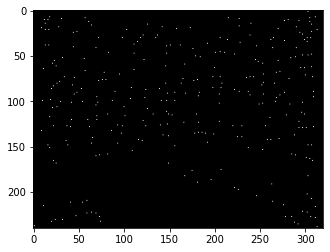

In [41]:
plt.imshow(x[4][0]*255, cmap = 'gray')

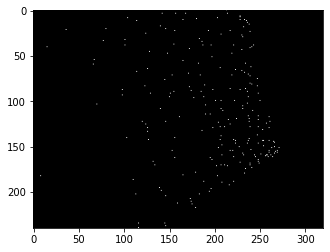

In [42]:
plt.imshow(x[5][0]*255, cmap = 'gray')